# Significant Wave Height at Bilbao Buoy 

In [30]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt

os.chdir("C:/Users/user/Victor/Trabajo/ExtremeCorrection/")
sys.path.append(os.path.abspath('C:/Users/user/Victor/Trabajo/ExtremeCorrection/src'))

Load the data

In [31]:
bilbao_buoy_data = np.loadtxt("Data/Bilbao/matriz_13_Boya.txt")

In [32]:
bilbao_buoy_data = bilbao_buoy_data[:,:5]

In [33]:
df_hs = pd.DataFrame({
    "yyyy": bilbao_buoy_data[:,0].astype(np.int64),
    "mm": bilbao_buoy_data[:,1].astype(np.int64),
    "dd": bilbao_buoy_data[:,2].astype(np.int64),
    "hh": bilbao_buoy_data[:,3].astype(np.int64),
    "Hs": bilbao_buoy_data[:,4].astype(np.float64),
    })

In [34]:
df_hs.head()

,yyyy,mm,dd,hh,Hs
0,1985,2,21,9,1.3
1,1985,2,22,9,1.0
2,1985,2,22,12,0.9
3,1985,2,22,15,1.0
4,1985,2,22,18,0.9


In [298]:
df_hs2 = df_hs.copy()
df_hs2 = df_hs2.rename(columns={
    'yyyy': 'year',
    'mm': 'month',
    'dd': 'day',
    'hh': 'hour'
})
time = pd.to_datetime(df_hs2[['year', 'month', 'day', 'hour']], format="%Y-%m-%d %h:m%")

In [307]:
year_interval = (time.iloc[-1] - time.iloc[0]).total_seconds() / (365.25 * 24 * 3600)
print("Nº of years in the sample: ", year_interval)
frequency_per_year = len(df_hs) / year_interval
print("Mean nº of observations per year: ", frequency_per_year)

Nº of years in the sample:  24.38866073465663
Mean nº of observations per year:  6386.246530490058


Si hay que rellenar tiempos:

In [ ]:
# Renombrar columnas para compatibilidad con pd.to_datetime
df = df_hs.copy()
df = df.rename(columns={'yyyy': 'year', 'mm': 'month', 'dd': 'day', 'hh': 'hour'})

# Crear columna datetime a partir de las columnas individuales
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df = df.set_index('datetime').sort_index()

# Nos quedamos solo con la columna Hs
df = df[['Hs']]

# Crear un índice completo de horas desde el mínimo hasta el máximo
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')

# Reindexar el DataFrame para incluir todas las horas
df_full = df.reindex(full_index)

# Función para rellenar NaNs con promedio del anterior y siguiente, o solo anterior
def custom_fill(series):
    series = series.copy()
    for i in range(1, len(series) - 1):
        if pd.isna(series[i]):
            series[i] = 0 
            prev_val = series[i - 1]
            next_val = series[i + 1]
            if pd.notna(next_val):
                series[i] = (prev_val + next_val) / 2
            else:
                series[i] = prev_val
    if pd.isna(series[-1]):
        series[-1] = series[-2]
    return series

# Aplicar función personalizada
df_full['Hs'] = custom_fill(df_full['Hs'].values)

df_full = df_full.reset_index().rename(columns={'index': 'datetime'})

# Extraer componentes de fecha y hora
df_full['yyyy'] = df_full['datetime'].dt.year
df_full['mm'] = df_full['datetime'].dt.month
df_full['dd'] = df_full['datetime'].dt.day
df_full['hh'] = df_full['datetime'].dt.hour

# Reorganizar columnas al estilo original
df_full = df_full[['yyyy', 'mm', 'dd', 'hh', 'Hs']]

In [216]:
df_full.head()

,yyyy,mm,dd,hh,Hs
0,1985,2,21,9,1.3
1,1985,2,21,10,0.0
2,1985,2,21,11,0.0
3,1985,2,21,12,0.0
4,1985,2,21,13,0.0


In [106]:
df_full.to_csv(r"C:\Users\user\Victor\Trabajo\ExtremeCorrection\Data\Bilbao\Boya_Bilbao_historic_filled.csv")

Mean number of observations per year

In [107]:
freq = len(df_hs)/(df_hs['yyyy'].max()-df_hs['yyyy'].min())/24
freq

371.1666666666667

## Generate the simulated data with an ARMA

In [ ]:
from src.arma_sim import ArmaSimulation

arma = ArmaSimulation(df_hs, var='Hs', freq=frequency_per_year, arma_order=(1,0,1), distribution="ecdf", n_components=4)
ny_sim = 100
hs_sim = arma.generate_sim(ny_sim = ny_sim)   # We select the number of years of simulations

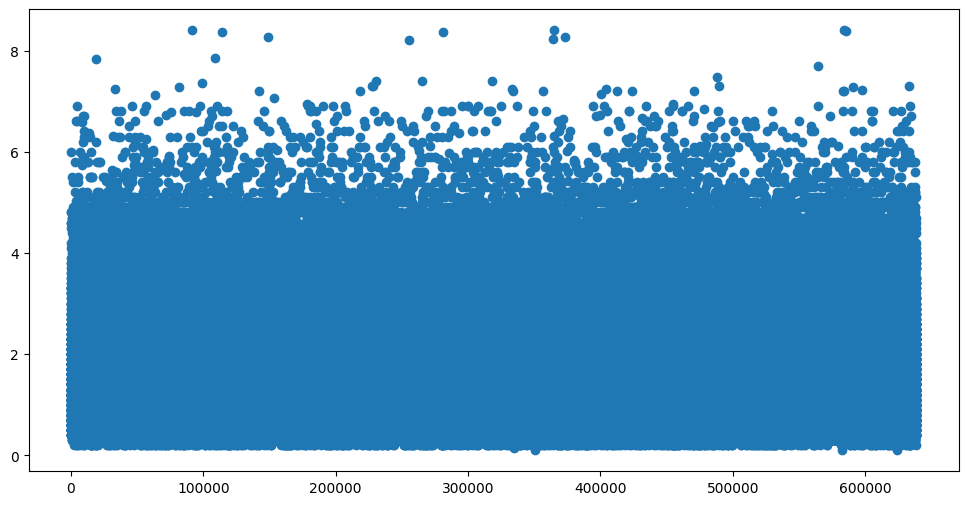

In [309]:
plt.figure(figsize=(12,6))
plt.scatter(np.arange(0,int(ny_sim*frequency_per_year)), hs_sim)
plt.show()

In [357]:
# Starting date within the safe pandas timestamp range
start_date = '2000-01-01 00:00:00'

# Generate date range in 100 years chunks
freq_per_year_minutes = int((365.25 * 24 * 60) / frequency_per_year)
date_range = pd.date_range(start=start_date, periods=int(ny_sim*frequency_per_year), freq=f'{freq_per_year_minutes}min')  

99.56476918396837

In [314]:
year_simulated = np.array([], dtype=np.int32)
month_simulated = np.array([], dtype=np.int32)
day_simulated = np.array([], dtype=np.int32)
hour_simulated = np.array([], dtype=np.int32)
for i in range(len(hs_sim)//len(date_range)):
    year_simulated = np.concatenate([year_simulated, date_range.year + 100*i])
    month_simulated = np.concatenate([month_simulated, date_range.month])
    day_simulated = np.concatenate([day_simulated, date_range.day])
    hour_simulated = np.concatenate([hour_simulated, date_range.hour])

In [315]:
df_sim = pd.DataFrame({
    'yyyy': year_simulated,
    'mm':  month_simulated,
    'dd': day_simulated,
    'hh': hour_simulated,
    'Hs': hs_sim
})

In [353]:
df_sim.head()

,yyyy,mm,dd,hh,Hs
0,2000,1,1,0,3.3
1,2000,1,1,1,0.9
2,2000,1,1,2,2.7
3,2000,1,1,4,1.0
4,2000,1,1,5,2.3


Save simulated data

In [317]:
df_sim.to_csv("Data/Bilbao/Boya_Bilbao_sim_ecdf_prueba.csv")

## Correction

In [ ]:
from src.gev_extremecorrection import Gev_ExtremeCorrection

In [322]:
config = {
    'var': 'Hs',
    'yyyy_var': 'yyyy',
    'mm_var': 'mm',
    'dd_var': 'dd',
    'freq': frequency_per_year,
    'folder': 'Figures/Hs_Bilbao_ecdf_prueba'
}

Initialize the correction

In [323]:
extr_corr = Gev_ExtremeCorrection(
    data = df_hs,
    config = config,
    conf = 0.95
)

### Apply historical correction

In [324]:
extr_corr.apply_correction(fit_diag=True)   # fit_diag = True, to plot the diagnostics plots (QQ-Plot and PP-plot)
extr_corr.return_period_plot()              # Default to plot only the no corrected data 

In [325]:
extr_corr.gev_parameters    # shape parameter has changed the sign

[5.588346992446635, 0.7762084826818324, -0.09780432912959289]

### Apply simulated correction

In [326]:
extr_corr.apply_correction_sim(simulated_data = df_sim)   # Apply the correction in the simulated data
extr_corr.sim_return_period_plot()                        # Default to plot the corrected and no corrected data
extr_corr.interval_sim_return_period_plot()               # Comparative of no corrected vs corrected simulated data in the historical range
extr_corr.time_series_plot(sim=False)                     # Time series of both corrected and no-corrected data

Dataframe with the corrected simulation

In [327]:
new_sim_data = extr_corr.sim_pit_data_corrected
new_df_sim = df_sim.copy()
new_df_sim['Hs'] = new_sim_data

In [123]:
new_df_sim.to_csv("Data/Bilbao/Boya_Bilbao_sim_ecdf_filled_corrected.csv")

## Obtener POTs de la serie tanto corregida como sin corregir

In [328]:
from src.optimal_threshold_studentized import OptimalThreshold

In [ ]:
# df_sim = pd.read_csv("Data/Bilbao/Boya_Bilbao_sim_gaussmix.csv")
# new_df_sim = pd.read_csv("Data/Bilbao/Boya_Bilbao_sim_gaussmix_corrected.csv")

In [361]:
opt_thres = OptimalThreshold(df_hs['Hs'].values)
opt_thres.threshold_peak_extraction(
    threshold=3,
    n0=10,
    min_peak_distance=11*24
)

optimal_threshold = opt_thres.threshold_studentized_residuals(
                siglevel=0.01,
                plot_flag=True,
                filename=f"{extr_corr.folder}/OptimalThreshold/OptimalThreshold",
                display_flag=False
                )

opt_thres.threshold_peak_extraction(
    threshold=optimal_threshold,
    n0=10,
    min_peak_distance=11*24
)

In [362]:
optimal_threshold

3.1

In [363]:
len(opt_thres.pks)

178

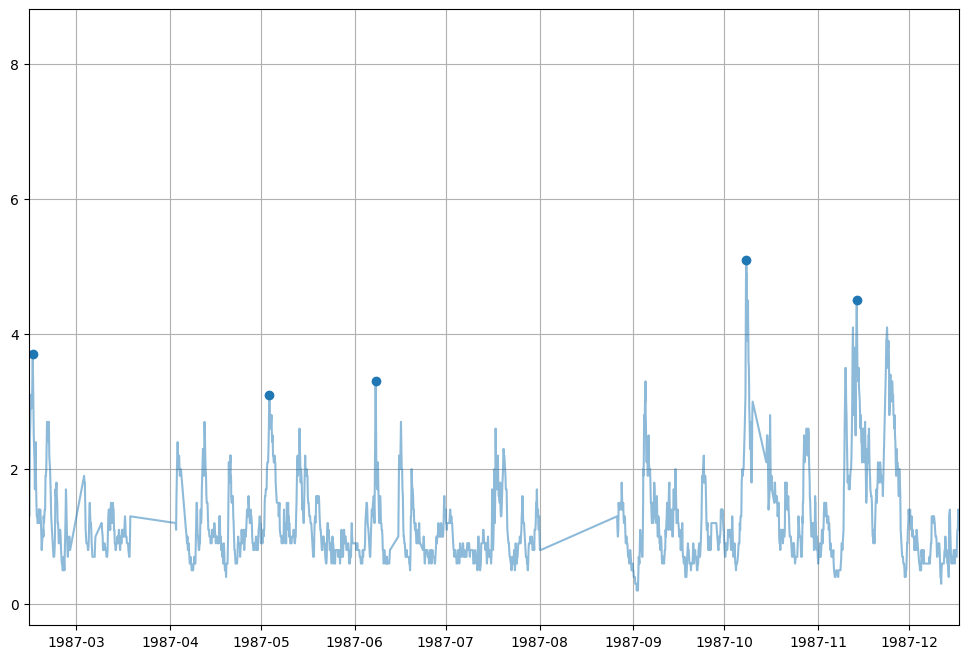

In [274]:
plt.figure(figsize=(12,8))

plt.plot(df_hs2['time'], df_hs2['Hs'], alpha=0.5)
plt.scatter(df_hs2['time'][opt_thres.locs], df_hs2['Hs'][opt_thres.locs])
plt.xlim(df_hs2['time'][4000], df_hs2['time'][6000])
plt.grid()
plt.show()

In [246]:
len(df_hs) / 11/24

589.969696969697

In [364]:
len(opt_thres.pks)/24.3

7.325102880658436

In [240]:
len(df_hs['Hs'].values[df_hs['Hs'].values > optimal_threshold])

7109

In [333]:
opt_thres.autocorrelations[:,2] < 0.01

array([False, False, False, False, False])

In [334]:
import numpy as np
import matplotlib.pyplot as plt

def mean_residual_life_plot(data, thresholds=None, min_exceedances=10):
    data = np.sort(data)
    if thresholds is None:
        thresholds = np.linspace(np.min(data), np.max(data)*0.9, 100)
    
    means = []
    valid_thresholds = []

    for u in thresholds:
        excesses = data[data > u] - u
        if len(excesses) >= min_exceedances:
            means.append(np.mean(excesses))
            valid_thresholds.append(u)

    plt.figure(figsize=(8, 5))
    plt.plot(valid_thresholds, means, marker='o', linestyle='-')
    plt.xlabel('Threshold')
    plt.ylabel('Mean Excess')
    plt.title('Mean Residual Life Plot')
    plt.grid(True)
    plt.show()


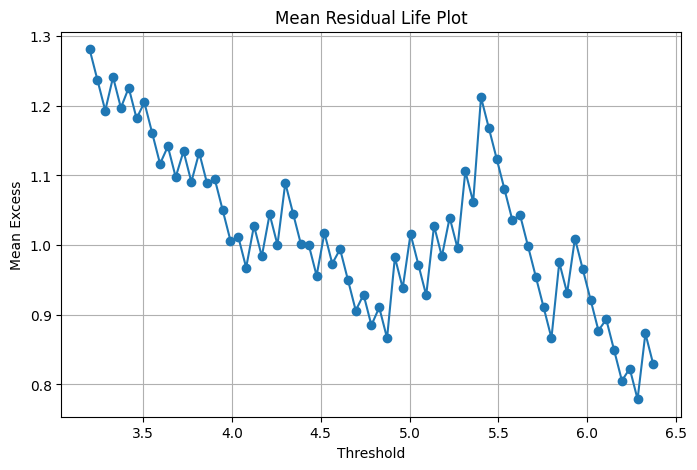

In [335]:
mean_residual_life_plot(opt_thres.pks)

Threshold óptimo

In [336]:
optimal_threshold

3.1

In [359]:
hist_poiss_param = len(opt_thres.pks) / year_interval # (df_hs['yyyy'].max()-df_hs['yyyy'].min()+1)
hist_poiss_param

7.298473743048117

Simulación sin corregir

In [360]:
opt_thres_sim = OptimalThreshold(df_sim['Hs'].values)
opt_thres_sim.threshold_peak_extraction(
    threshold=optimal_threshold,
    n0=10,
    min_peak_distance=11*24
)
sim_poiss_param = len(opt_thres_sim.pks) / 100
sim_poiss_param

17.26527660600217

In [343]:
opt_thres_sim.autocorrelations

array([[ 1.00000000e+00, -1.08660446e-01,  6.36360276e-06],
       [ 2.00000000e+00,  3.53678366e-02,  1.42943453e-01],
       [ 3.00000000e+00, -1.07942803e-02,  6.54993290e-01],
       [ 4.00000000e+00, -6.15680988e-02,  1.07644754e-02],
       [ 5.00000000e+00,  1.00141759e-02,  6.78654672e-01]])

In [344]:
opt_thres_sim.locs

array([    22,    297,    606, ..., 637588, 637997, 638483], dtype=int64)

Simulación corregida

In [347]:
opt_thres_sim_corrected = OptimalThreshold(new_df_sim['Hs'].values)
opt_thres_sim_corrected.threshold_peak_extraction(
    threshold=optimal_threshold,
    n0=10,
    min_peak_distance=11*24
)
sim_poiss_param_corrected = len(opt_thres_sim_corrected.pks) / 100
sim_poiss_param_corrected

17.13

In [348]:
opt_thres_sim_corrected.locs

array([    22,    297,    606, ..., 637588, 637997, 638483], dtype=int64)

## Grafico

In [349]:
from scipy import stats
from src.gev_utils import dq_gev, nll_gev
import numdifftools as ndt

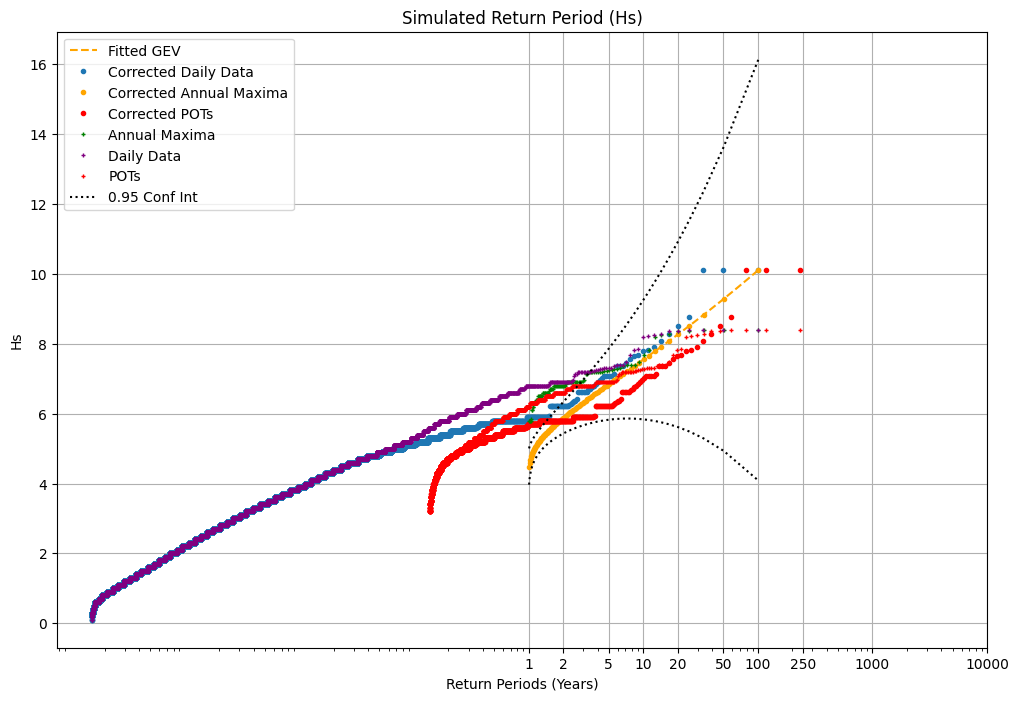

In [350]:
x_vals_gev_sim = np.linspace(extr_corr.sim_max_data_corrected[0], extr_corr.sim_max_data_corrected[-1], 1000)
# Return period from GEV fitted
gev_probs_fitted = stats.genextreme.cdf(x_vals_gev_sim, extr_corr.gev_parameters[2], loc=extr_corr.gev_parameters[0], scale=extr_corr.gev_parameters[1])
T_gev_fitted = 1.0 / (1.0 - gev_probs_fitted) #*(40/len(max_data_hist[wt]))#(10000/n_peaks)

# Corrected peaks: re-check CDF and return periods
ecdf_annmax_probs_corrected_sim = stats.genextreme.cdf(
    stats.genextreme.ppf(extr_corr.ecdf_annmax_probs_sim, extr_corr.gev_parameters[2], loc=extr_corr.gev_parameters[0], scale=extr_corr.gev_parameters[1]),
    extr_corr.gev_parameters[2], loc=extr_corr.gev_parameters[0], scale=extr_corr.gev_parameters[1]
)
T_ev_corrected_sim = 1.0 / (1.0 - ecdf_annmax_probs_corrected_sim) #*(40/len(max_data_hist[wt]))#(10000/n_peaks)

# Daily corrected data
ecdf_pt_probs_corrected_sim = np.arange(1, extr_corr.n_sim_pit + 1) / (extr_corr.n_sim_pit + 1)
T_pt_corrected_sim = 1.0 / (1.0 - ecdf_pt_probs_corrected_sim) / extr_corr.freq #/ n_return_period[wt] 

# POT (uncorrected)
T_pot_sim = 1.0 / (1.0 - extr_corr.ecdf_annmax_probs_sim) #*(40/len(max_data_hist[wt]))#(10000/n_peaks)

# Confidence intervals
dqgev_sim = dq_gev(extr_corr.ecdf_annmax_probs_sim, p=[extr_corr.gev_parameters[0], extr_corr.gev_parameters[1], extr_corr.gev_parameters[2]])
aux_fun = lambda x: nll_gev(extr_corr.max_data, x)
hess = ndt.Hessian(aux_fun, step=1e-4)  # Añado el step para que no de problemas de inestabilidad
hessians_gev_sim = hess([extr_corr.gev_parameters[0], extr_corr.gev_parameters[1], extr_corr.gev_parameters[2]])
invI0_gev_sim = np.linalg.inv(hessians_gev_sim)

stdDq_gev_sim = np.sqrt(np.sum((dqgev_sim.T@invI0_gev_sim) * dqgev_sim.T, axis=1)) # Es lo mismo 
stdup_gev_sim = extr_corr.sim_max_data_corrected + stdDq_gev_sim*stats.norm.ppf(1-(1-extr_corr.conf)/2,0,1)
stdlo_gev_sim = extr_corr.sim_max_data_corrected - stdDq_gev_sim*stats.norm.ppf(1-(1-extr_corr.conf)/2,0,1)


# Plot
# Gráfico
fig = plt.figure(figsize=(12,8))
ax= fig.add_subplot()
ax.semilogx(T_gev_fitted, np.sort(x_vals_gev_sim), color = 'orange',linestyle='dashed', label='Fitted GEV')

# Corrected data 
# if show_corrected:
ax.semilogx(T_pt_corrected_sim, np.sort(extr_corr.sim_pit_data_corrected), linewidth=0, marker='o',markersize=3, label=f'Corrected Daily Data')
ax.semilogx(T_ev_corrected_sim, stats.genextreme.ppf(extr_corr.ecdf_annmax_probs_sim, extr_corr.gev_parameters[2], loc=extr_corr.gev_parameters[0], scale=extr_corr.gev_parameters[1]), color = 'orange',linewidth=0, marker='o',markersize=3, label=f'Corrected Annual Maxima')

pots_corrected = new_df_sim['Hs'].values[opt_thres_sim_corrected.locs]
ecdf_pot_probs_corrected_sim = np.arange(1,len(pots_corrected)+1)/(len(pots_corrected)+1)
T_pot_corrected_sim = 1/(1-ecdf_pot_probs_corrected_sim)/hist_poiss_param
ax.semilogx(T_pot_corrected_sim, np.sort(pots_corrected), color = 'red',linewidth=0, marker='o',markersize=3, label=f'Corrected POTs')



# No corrected data
# if show_uncorrected:
ax.semilogx(T_pot_sim, extr_corr.sim_max_data_sorted, color="green", linewidth=0, marker='+',markersize=3, label='Annual Maxima')
ax.semilogx(T_pt_corrected_sim, extr_corr.sim_pit_data_sorted, color="purple", linewidth=0, marker='+',markersize=3, label='Daily Data')

pots_sim = df_sim['Hs'].values[opt_thres_sim.locs]
ecdf_pot_probs_sim = np.arange(1,len(pots_sim)+1)/(len(pots_sim)+1)
T_pot_sim = 1/(1-ecdf_pot_probs_sim)/hist_poiss_param
ax.semilogx(T_pot_sim, np.sort(pots_sim), color = 'red',linewidth=0, marker='+',markersize=3, label=f'POTs')

# Confidence interval for fitted GEV
ax.semilogx(T_ev_corrected_sim, stdup_gev_sim, color = "black",linestyle='dotted', label=f'{extr_corr.conf} Conf Int')
ax.semilogx(T_ev_corrected_sim, stdlo_gev_sim, color = "black",linestyle='dotted')

ax.set_xlabel("Return Periods (Years)")
ax.set_ylabel(f"{extr_corr.var}")
ax.set_title(f"Simulated Return Period ({extr_corr.var})")
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_xlim(right=10000)
ax.legend(loc='upper left')
ax.grid()
# if extr_corr.folder is not None:
    # plt.savefig(f"{extr_corr.folder}/Simulation_ReturnPeriod_con_POTs_1.png", dpi=300)
plt.show()
# plt.close(fig)

In [351]:
print("Historical Poisson parameter:", hist_poiss_param)
print("Simulation Poisson parameter:", sim_poiss_param)
print("Corrected Simulation Poisson parameter:", sim_poiss_param_corrected)

Historical Poisson parameter: 7.298473743048117
Simulation Poisson parameter: 17.19
Corrected Simulation Poisson parameter: 17.13
